In [1]:
import scipy.io
import scipy.misc
import tensorflow as tf
import numpy as np
import time
from IPython.display import Image

from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD

from keras.utils.visualize_util import plot

Couldn't import dot_parser, loading of dot files will not be possible.


Using TensorFlow backend.


In [2]:
content_file_name = '1-content.jpg'
style_file_name = '1-style.jpg'

In [3]:
data = scipy.io.loadmat('./imagenet-vgg-verydeep-19.mat')

image_content = scipy.misc.imread('./images/'+content_file_name)
image_content = image_content.astype('float32')
image_content = np.ndarray.reshape(image_content,((1,) + image_content.shape)) # 1 means batch_size
#image_content = np.ndarray.reshape(image_content.shape + (1,)) it is needed to handle gray scale image 

image_style = scipy.misc.imread('./images/'+style_file_name)
image_style = image_style.astype('float32')
image_style = np.ndarray.reshape(image_style,((1,) + image_style.shape)) # 1 means batch_size
#image_style = np.ndarray.reshape(image_style.shape + (1,)) it is needed to handle gray scale image 

In [4]:
print(image_content.shape)
print(image_style.shape)

(1, 450, 845, 3)
(1, 507, 640, 3)


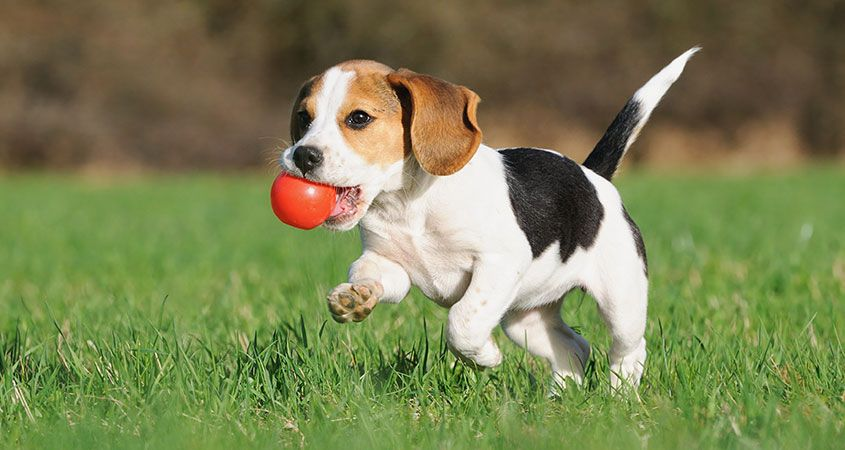

In [5]:
# content image
Image(filename = './images/'+content_file_name)

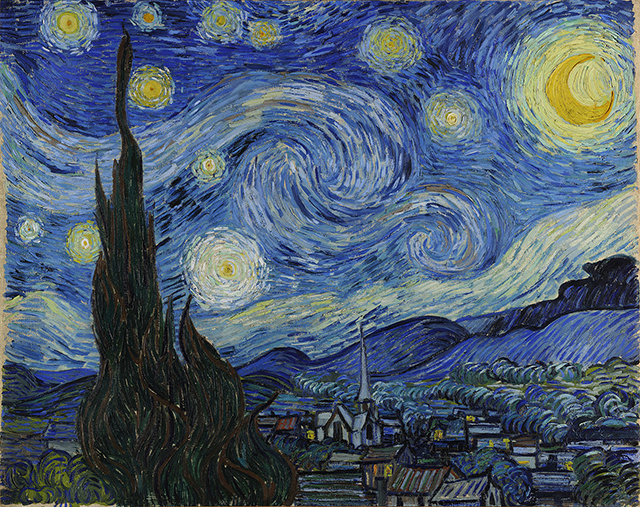

In [6]:
# style image
Image(filename = './images/'+style_file_name)

In [7]:
def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)

def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

def preprocess(image, mean_pixel):
    return (image - mean_pixel).astype('float32')

def unprocess(image, mean_pixel):
    return (image + mean_pixel).astype('float32')

In [8]:
def net(input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    weights = data['layers'][0]
    
    net = {}
    current = input_image
    for i, name in enumerate(layers):
        #print(i,name)
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
         

            kernels = np.transpose(kernels, (1, 0, 2, 3))
            #print('kernel:', kernels.shape)
            #print('bias:', bias.shape)
            
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
            #print('current:', current)
            
        elif kind == 'relu':
            current = tf.nn.relu(current)
            #print('current:', current)
        elif kind == 'pool':
            current = _pool_layer(current)
            #print('current:', current)
        net[name] = current
        #print(' ')

    assert len(net) == len(layers)
    return net#, mean_pixel

In [9]:
def keras_model(input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    weights = data['layers'][0]
    
    model = Sequential()
    
    current = input_image
    for i, name in enumerate(layers):
        #print(i,name)
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
                 
            kernels_keras = np.transpose(kernels, (3,2,1, 0))
            if i==0:
                model.add(ZeroPadding2D((1,1),input_shape=(input_image.shape[3],input_image.shape[1],input_image.shape[2]),name="Zero Padding Layer"))
            else:
                model.add(ZeroPadding2D((1,1)))
            
            model.add(Convolution2D(bias.size, 3, 3, name=name, weights=[kernels_keras,bias[0]]))      
        elif kind == 'relu':
            model.add(Activation('relu', name=name))
        elif kind == 'pool':
            model.add(MaxPooling2D((2,2), name=name, border_mode='same', strides=(2,2)))
             
    return model 

In [10]:
mean = data['normalization'][0][0][0]
mean_pixel = np.mean(mean, axis=(0, 1))

In [11]:
content_pre = preprocess(image_content, mean_pixel)
content_keras_model = keras_model(content_pre)

In [12]:
content_keras_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Zero Padding Layer (ZeroPadding2 (None, 3, 452, 847)   0           zeropadding2d_input_1[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 64, 450, 845)  1792        Zero Padding Layer[0][0]         
____________________________________________________________________________________________________
relu1_1 (Activation)             (None, 64, 450, 845)  0           conv1_1[0][0]                    
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 64, 452, 847)  0           relu1_1[0][0]                    
___________________________________________________________________________________________

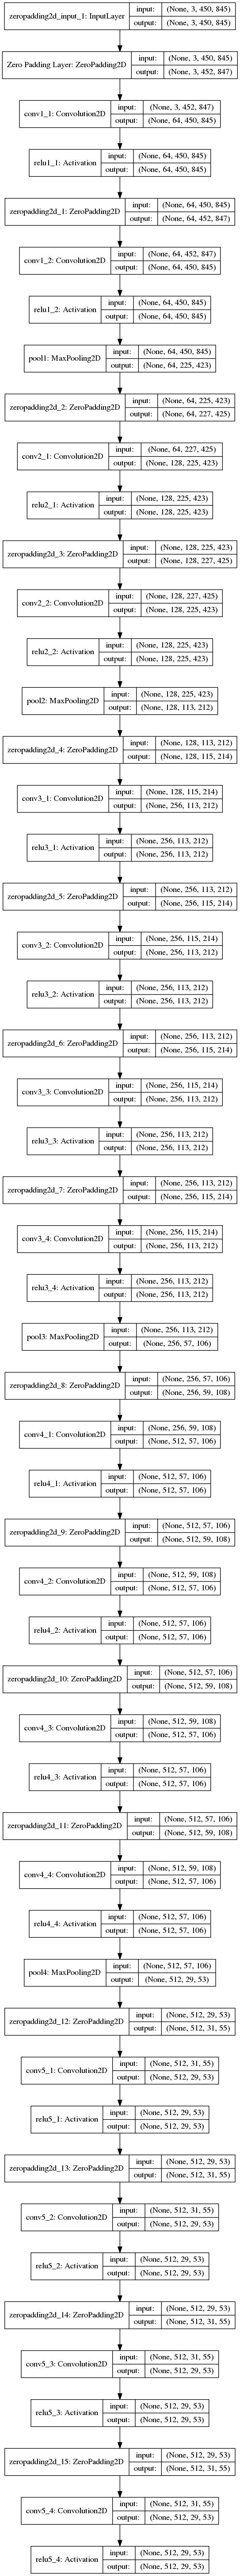

In [13]:
plot(content_keras_model, show_shapes=True, to_file='./images/model.png')
Image("./images/model.png")

In [14]:
# CONTENT_LAYER = 'relu4_2'
# content_features = {}

# with tf.Session() as sess:
#     content_pre = preprocess(image_content, mean_pixel)
#     content_net = net(np.squeeze(data['layers']), content_pre)
#     content_features[CONTENT_LAYER] = content_net[CONTENT_LAYER].eval()

#CONTENT_LAYERS = ('conv1_1', 'conv2_1', 'conv4_1', 'conv4_2')
CONTENT_LAYERS = ('relu4_2',)
content_features = {}
content_keras_features ={}


content_pre = preprocess(image_content, mean_pixel)
transp_content_image= np.transpose(content_pre,(0,3,1,2)) 

for layer in CONTENT_LAYERS:
    tmpmodel=Model(input=content_keras_model.input, output=content_keras_model.get_layer(layer).output) 
    content_keras_features[layer]=np.transpose(tmpmodel.predict(transp_content_image),(0,2,3,1))
    print('content_keras_feaures:', layer, content_keras_features[layer].shape)
   

('content_keras_feaures:', 'relu4_2', (1, 57, 106, 512))


In [15]:
content_features=content_keras_features

In [16]:
#STYLE_LAYERS = ('conv3_1','conv5_1')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

style_pre = preprocess(image_style, mean_pixel)
transp_style_image= np.transpose(style_pre,(0,3,1,2)) 
style_keras_model = keras_model(style_pre)

style_keras_features ={}
Style_features = {}

for layer in STYLE_LAYERS:
    tmpmodel=Model(input=style_keras_model.input, output=style_keras_model.get_layer(layer).output) 
    features=np.transpose(tmpmodel.predict(transp_style_image),(0,2,3,1))
          
    print('feaures:', layer, features.shape)
    features = np.reshape(features, (-1, features.shape[3]))
    gram = np.matmul(features.T, features) / features.size
    style_keras_features[layer] = gram
        


('feaures:', 'relu1_1', (1, 507, 640, 64))
('feaures:', 'relu2_1', (1, 254, 320, 128))
('feaures:', 'relu3_1', (1, 127, 160, 256))
('feaures:', 'relu4_1', (1, 64, 80, 512))
('feaures:', 'relu5_1', (1, 32, 40, 512))


In [17]:
style_features=style_keras_features

In [18]:
# make stylized image using backpropogation
initial = None
#initial = scipy.misc.imread('./images/cat.jpg')
if initial is None:
    noise = np.random.normal(size=image_content.shape, scale=np.std(image_content) * 0.1)
    initial = tf.random_normal(image_content.shape) * 0.256
else:
    initial = np.array([preprocess(initial, mean_pixel)])
    initial = initial.astype('float32')

In [19]:
image = tf.Variable(initial)
image_net = net(image)


In [20]:
#content_weight = 5e0
#style_weight = 1e4
#tv_weight = 1e3
#learning_rate = 1e0

content_weight= 5e0
style_weight= 1e2
tv_weight = 1e2
learning_rate = 1e1

iterations =  1000
checkpoint_iterations = 20
print_iterations = 10


In [21]:
# content loss
# content_loss = content_weight * (2 * tf.nn.l2_loss(
#         image_net[CONTENT_LAYER] - content_features[CONTENT_LAYER]) / 
#         content_features[CONTENT_LAYER].size)
content_loss = 0
content_losses = []
for content_layer in CONTENT_LAYERS:
    content_losses.append(2 * tf.nn.l2_loss(
                          image_net[content_layer] - content_features[content_layer]) / 
                          content_features[content_layer].size)
content_loss += content_weight * reduce(tf.add, content_losses)

In [22]:
content_loss

<tf.Tensor 'add_32:0' shape=() dtype=float32>

In [23]:
# style loss
style_loss = 0
style_losses = []
for style_layer in STYLE_LAYERS:
    layer = image_net[style_layer]
    _, height, width, number = map(lambda i: i.value, layer.get_shape())
    size = height * width * number
    feats = tf.reshape(layer, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats) / size
    style_gram = style_features[style_layer]
    style_losses.append(2 * tf.nn.l2_loss(gram - style_gram) / style_gram.size)
style_loss += style_weight * reduce(tf.add, style_losses)

In [24]:
style_loss

<tf.Tensor 'add_33:0' shape=() dtype=float32>

In [25]:
def _tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

In [26]:
# total variation denoising
tv_y_size = _tensor_size(image[:,1:,:,:])
tv_x_size = _tensor_size(image[:,:,1:,:])
tv_loss = tv_weight * 2 * (
        (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:image_content.shape[1]-1,:,:]) /
            tv_y_size) +
        (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:image_content.shape[2]-1,:]) /
            tv_x_size))

In [27]:
print(image)

Tensor("Variable/read:0", shape=(1, 450, 845, 3), dtype=float32)


In [28]:
# overall loss
loss = content_loss + style_loss + tv_loss

In [29]:
# optimizer setup
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [30]:
def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)

In [31]:
# optimization
best_loss = float('inf')
best = None

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    for i in range(iterations):
        print(i)
        train_step.run()
        
        if i % checkpoint_iterations == 0 or i == iterations - 1:
            this_loss = loss.eval()
            if this_loss < best_loss:
                best_loss = this_loss
                best = image.eval()
            # save a check point
            import os
            try:
                os.makedirs('./checks/'+str.split(content_file_name,'.')[0])
            except OSError:
                pass
            timestr = time.strftime("%Y%m%d_%H%M%S")
            filename_cp = './checks/'+str.split(content_file_name,'.')[0]+'/'+timestr+'.jpg'
            cp = unprocess(best.reshape(image_content.shape[1:]), mean_pixel)
            imsave(filename_cp, cp)
        
        if i % print_iterations == 0 or i == iterations - 1:
            print('Iteration %d/%d' % (i + 1, iterations))
            print('  content loss: %g' % content_loss.eval())
            print('    style loss: %g' % style_loss.eval())
            print('       tv loss: %g' % tv_loss.eval())
            print('    total loss: %g' % loss.eval())

    output = unprocess(best.reshape(image_content.shape[1:]), mean_pixel)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
0
Iteration 1/1000
  content loss: 1.19906e+06
    style loss: 7.51019e+07
       tv loss: 22836
    total loss: 7.63238e+07
1
2
3
4
5
6
7
8
9
10
Iteration 11/1000
  content loss: 2.64237e+06
    style loss: 7.55705e+06
       tv loss: 231508
    total loss: 1.04309e+07
11
12
13
14
15
16
17
18
19
20
Iteration 21/1000
  content loss: 2.41742e+06
    style loss: 2.60908e+06
       tv loss: 252256
    total loss: 5.27876e+06
21
22
23
24
25
26
27
28
29
30
Iteration 31/1000
  content loss: 2.14474e+06
    style loss: 1.1275e+06
       tv loss: 219130
    total loss: 3.49137e+06
31
32
33
34
35
36
37
38
39
40
Iteration 41/1000
  content loss: 1.87824e+06
    style loss: 669862
       tv loss: 196995
    total loss: 2.7451e+06
41
42
43
44
45
46
47
48
49
50
Iteration 51/1000
  content loss: 1.67158e+06
    style loss: 469910
       tv loss: 183621
    total loss: 2.32511e+06
51
52
53
54
55
56
57
58
59
60
Iteration 61/1000

In [32]:
imsave('./images/output_'+content_file_name, output)

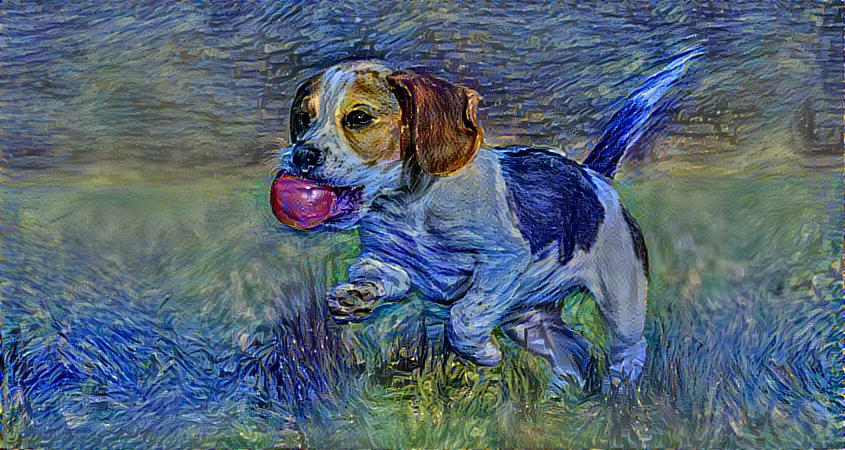

In [33]:
Image(filename = './images/output_'+content_file_name)